In [6]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
class VacuumEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=(5, 5)):
        super(VacuumEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(3)  # 0=forward, 1=rotate counter-clockwise, 2=rotate clockwise
        self.observation_space = spaces.Dict({
            "agent_pos": spaces.MultiDiscrete([grid_size[0], grid_size[1]]), # agent position on the grid
            "agent_orient": spaces.Discrete(8), # TODO: can the agent face 4 or 8 directions? What amount of local information do we need?
            "local_view": spaces.MultiBinary(3)  # [front, left, right]
        })

        self.orientations = {
            0: (-1, 0),   # N
            1: (-1, 1),   # NE
            2: (0, 1),    # E
            3: (1, 1),    # SE
            4: (1, 0),    # S
            5: (1, -1),   # SW
            6: (0, -1),   # W
            7: (-1, -1),  # NW
        } # define the 8 directions

        self.reset() # reset the environment when initialized

    def reset(self):
        self.agent_pos = [0, 0] # TODO: agent starting position is upper left corner for now
        self.agent_orient = 2  # # TODO: agent starting orientation is facing right
        self.cleaned_map = np.zeros(self.grid_size, dtype=np.uint8) # map of cleaned tiles
        self.dirt_map = np.ones(self.grid_size, dtype=np.uint8) # TODO: all tiles are initially dirty, no dirt map for now
        self.cleaned_map[tuple(self.agent_pos)] = 1
        self.dirt_map[tuple(self.agent_pos)] = 0
        return self._get_obs()

    def _get_obs(self):
        """Check surroundings and return observation"""
        front = self._check_cell_in_direction(self.agent_orient)
        left = self._check_cell_in_direction((self.agent_orient - 2) % 8)
        right = self._check_cell_in_direction((self.agent_orient + 2) % 8)
        return {
            "agent_pos": np.array(self.agent_pos, dtype=np.int32),
            "agent_orient": self.agent_orient,
            "local_view": np.array([front, left, right], dtype=np.uint8)
        }

    def _check_cell_in_direction(self, direction):
        """Check the dirt map in a specific direction"""
        dx, dy = self.orientations[direction]
        x, y = self.agent_pos[0] + dx, self.agent_pos[1] + dy
        if 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1]:
            return 1 if self.dirt_map[x, y] > 0 else 0
        return 0  # out-of-bounds treated as clean

    def step(self, action):
        """Take a step in the environment"""
        reward = 0
        moved = False

        if action == 0:  # move forward
            dx, dy = self.orientations[self.agent_orient]
            nx, ny = self.agent_pos[0] + dx, self.agent_pos[1] + dy
            if 0 <= nx < self.grid_size[0] and 0 <= ny < self.grid_size[1]:
                self.agent_pos = [nx, ny]
                moved = True
                reward -= 0.1  # forward movement cost
            else:
                reward -= 1.0  # invalid move (out-of-bounds)
        elif action == 1:  # rotate left
            self.agent_orient = (self.agent_orient - 1) % 8
            reward -= 0.05 # rotation cost
        elif action == 2:  # rotate right
            self.agent_orient = (self.agent_orient + 1) % 8
            reward -= 0.05 # rotation cost

        x, y = self.agent_pos
        if moved:
            # update dirt and cleaned maps
            if self.dirt_map[x, y] == 1:
                reward += 1.0
                self.dirt_map[x, y] = 0
                self.cleaned_map[x, y] = 1
            else:
                reward -= 0.5  # revisiting a cleaned tile

        done = np.all(self.dirt_map == 0) # check if all tiles are cleaned

        if done:
            reward += 10.0  # terminal bonus

        return self._get_obs(), reward, done, {} # {} is for gym compatibility; can include additional info

    def render(self, mode='human'):
        """Render the current state of the environment."""
        grid = np.full(self.grid_size, '.', dtype='<U1') # initialize grid with placeholders .
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if self.dirt_map[i, j]:
                    grid[i, j] = 'D' # dirt tile is represented by 'D'
                elif self.cleaned_map[i, j]:
                    grid[i, j] = '*' # cleaned tile is represented by '*'
        x, y = self.agent_pos
        grid[x, y] = 'A' # agent is represented by 'A'
        print("\n".join(" ".join(row) for row in grid))
        print(f"Orientation: {self.agent_orient}")
        print()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [3]:
# random baseline for 5x5 grid
env = VacuumEnv(grid_size=(5, 5))
obs = env.reset()
total_reward = 0
history = []

for _ in range(1000):
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    history.append((tuple(env.agent_pos), reward))
    total_reward += reward
    if done:
        break


In [4]:
df = pd.DataFrame(history, columns=["Position", "Reward"])
df["Step"] = range(1, len(df) + 1)

print(df)
print(f"\nTotal reward: {total_reward}")
print(f"Steps taken: {len(df)}")

    Position  Reward  Step
0     (0, 0)   -0.05     1
1     (0, 0)   -1.00     2
2     (0, 0)   -1.00     3
3     (0, 0)   -0.05     4
4     (0, 0)   -0.05     5
..       ...     ...   ...
429   (3, 4)   -0.05   430
430   (3, 4)   -0.05   431
431   (3, 4)   -0.05   432
432   (3, 4)   -0.05   433
433   (4, 4)   10.90   434

[434 rows x 3 columns]

Total reward: -84.69999999999936
Steps taken: 434


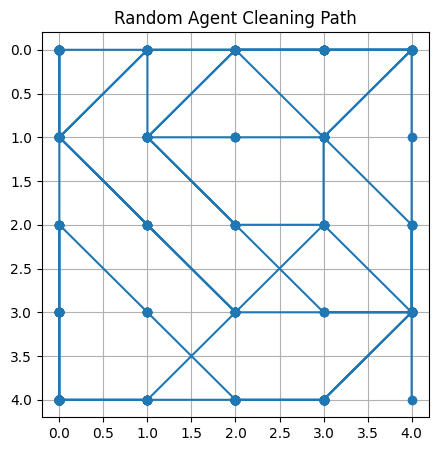

In [5]:
positions = [pos for pos, _ in history]
x_vals, y_vals = zip(*positions)

plt.figure(figsize=(5, 5))
plt.plot(y_vals, x_vals, marker='o')
plt.gca().invert_yaxis()
plt.title("Random Agent Cleaning Path")
plt.grid(True)
plt.show()

In [6]:
env.render()

* * * * *
* * * * *
* * * * *
* * * * *
* * * * A
Orientation: 4



##### this version includes the stay action, but random baseline will easily get stuck

In [15]:
class VacuumEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, grid_size=(5, 5)):
        super(VacuumEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4)  # 0=forward, 1=rotate left, 2=rotate right, 3=stay
        self.observation_space = spaces.Dict({
            "agent_pos": spaces.MultiDiscrete([grid_size[0], grid_size[1]]),
            "agent_orient": spaces.Discrete(8),
            "local_view": spaces.MultiBinary(3)  # [front, left, right] view
        })

        self.orientations = {
            0: (-1, 0),   # N
            1: (-1, 1),   # NE
            2: (0, 1),    # E
            3: (1, 1),    # SE
            4: (1, 0),    # S
            5: (1, -1),   # SW
            6: (0, -1),   # W
            7: (-1, -1),  # NW
        }

        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        self.agent_orient = 2  # Facing right initially
        self.cleaned_map = np.zeros(self.grid_size, dtype=np.uint8)
        self.dirt_map = np.ones(self.grid_size, dtype=np.uint8)
        self.cleaned_map[tuple(self.agent_pos)] = 1
        self.dirt_map[tuple(self.agent_pos)] = 0
        return self._get_obs()

    def _get_obs(self):
        front = self._check_cell_in_direction(self.agent_orient)
        left = self._check_cell_in_direction((self.agent_orient - 2) % 8)
        right = self._check_cell_in_direction((self.agent_orient + 2) % 8)
        return {
            "agent_pos": np.array(self.agent_pos, dtype=np.int32),
            "agent_orient": self.agent_orient,
            "local_view": np.array([front, left, right], dtype=np.uint8)
        }

    def _check_cell_in_direction(self, direction):
        dx, dy = self.orientations[direction]
        x, y = self.agent_pos[0] + dx, self.agent_pos[1] + dy
        if 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1]:
            return 0 if self.dirt_map[x, y] == 0 else 1
        return 0  # wall or out of bounds considered clean

    def step(self, action):
        reward = 0
        moved = False

        if action == 0:  # move forward
            dx, dy = self.orientations[self.agent_orient]
            nx, ny = self.agent_pos[0] + dx, self.agent_pos[1] + dy
            if 0 <= nx < self.grid_size[0] and 0 <= ny < self.grid_size[1]:
                self.agent_pos = [nx, ny]
                moved = True
                reward -= 0.1  # forward movement cost
            else:
                reward -= 1.0  # invalid move (out of bounds)
        elif action == 1:  # rotate left
            self.agent_orient = (self.agent_orient - 1) % 8
            reward -= 0.05
        elif action == 2:  # rotate right
            self.agent_orient = (self.agent_orient + 1) % 8
            reward -= 0.05
        elif action == 3:  # stay in place
            pass  # no movement or cost

        x, y = self.agent_pos
        if moved:
            if self.dirt_map[x, y] == 1:
                reward += 1.0
                self.dirt_map[x, y] = 0
                self.cleaned_map[x, y] = 1
            else:
                reward -= 0.5  # revisiting a cleaned tile

        done = np.all(self.dirt_map == 0)
        if done:
            reward += 10.0  # terminal reward

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        grid = np.full(self.grid_size, '.', dtype='<U1')
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if self.dirt_map[i, j]:
                    grid[i, j] = 'D'
                elif self.cleaned_map[i, j]:
                    grid[i, j] = '*'
        x, y = self.agent_pos
        grid[x, y] = 'A'
        print("\n".join(" ".join(row) for row in grid))
        print(f"Orientation: {self.agent_orient}")
        print()

In [19]:
env = VacuumEnv(grid_size=(5, 5))
obs = env.reset()
total_reward = 0
history = []

for _ in range(1000):  # limit steps to avoid infinite loop
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    history.append((tuple(env.agent_pos), reward))
    total_reward += reward
    if done:
        break


In [20]:
df = pd.DataFrame(history, columns=["Position", "Reward"])
df["Step"] = range(1, len(df) + 1)

print(df)
print(f"\nTotal reward: {total_reward}")
print(f"Steps taken: {len(df)}")

    Position  Reward  Step
0     (0, 0)    0.00     1
1     (0, 1)    0.90     2
2     (0, 1)   -0.05     3
3     (0, 1)    0.00     4
4     (0, 1)   -0.05     5
..       ...     ...   ...
995   (4, 0)   -0.05   996
996   (4, 0)   -1.00   997
997   (4, 0)   -0.05   998
998   (4, 0)   -1.00   999
999   (4, 0)   -1.00  1000

[1000 rows x 3 columns]

Total reward: -200.75000000000094
Steps taken: 1000


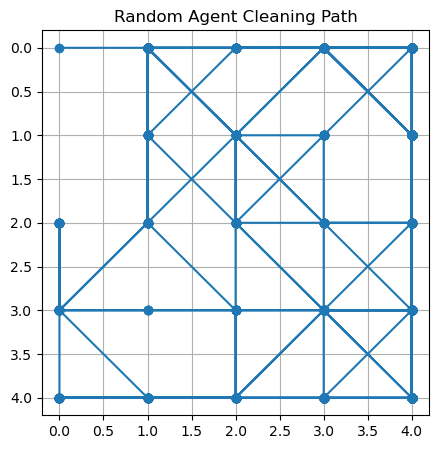

In [21]:
positions = [pos for pos, _ in history]
x_vals, y_vals = zip(*positions)

plt.figure(figsize=(5, 5))
plt.plot(y_vals, x_vals, marker='o')
plt.gca().invert_yaxis()
plt.title("Random Agent Cleaning Path")
plt.grid(True)
plt.show()

# Try PPO using gymnasium and stable_baseline

In [10]:
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

In [15]:
class VacuumEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, grid_size=(5, 5), render_mode=None):
        super().__init__()
        self.grid_size = grid_size
        self.render_mode = render_mode
        self.action_space = spaces.Discrete(3)  # forward, left, right
        self.observation_space = spaces.Dict({
            "agent_pos": spaces.MultiDiscrete([grid_size[0], grid_size[1]]),
            "agent_orient": spaces.Discrete(8),
            "local_view": spaces.MultiBinary(3)
        })

        self.orientations = {
            0: (-1, 0),   1: (-1, 1),
            2: (0, 1),    3: (1, 1),
            4: (1, 0),    5: (1, -1),
            6: (0, -1),   7: (-1, -1),
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_pos = [0, 0]
        self.agent_orient = 2  # facing right
        self.cleaned_map = np.zeros(self.grid_size, dtype=np.uint8)
        self.dirt_map = np.ones(self.grid_size, dtype=np.uint8)
        self.cleaned_map[tuple(self.agent_pos)] = 1
        self.dirt_map[tuple(self.agent_pos)] = 0
        obs = self._get_obs()
        return obs, {}  # Gymnasium format

    def _get_obs(self):
        front = self._check_cell_in_direction(self.agent_orient)
        left = self._check_cell_in_direction((self.agent_orient - 2) % 8)
        right = self._check_cell_in_direction((self.agent_orient + 2) % 8)
        return {
            "agent_pos": np.array(self.agent_pos, dtype=np.int32),
            "agent_orient": self.agent_orient,
            "local_view": np.array([front, left, right], dtype=np.int8)
        }

    def _check_cell_in_direction(self, direction):
        dx, dy = self.orientations[direction]
        x, y = self.agent_pos[0] + dx, self.agent_pos[1] + dy
        if 0 <= x < self.grid_size[0] and 0 <= y < self.grid_size[1]:
            return 1 if self.dirt_map[x, y] > 0 else 0
        return 0

    def step(self, action):
        reward = 0
        moved = False

        if action == 0:
            dx, dy = self.orientations[self.agent_orient]
            nx, ny = self.agent_pos[0] + dx, self.agent_pos[1] + dy
            if 0 <= nx < self.grid_size[0] and 0 <= ny < self.grid_size[1]:
                self.agent_pos = [nx, ny]
                moved = True
                reward -= 0.1
            else:
                reward -= 1.0
        elif action == 1:
            self.agent_orient = (self.agent_orient - 1) % 8
            reward -= 0.05
        elif action == 2:
            self.agent_orient = (self.agent_orient + 1) % 8
            reward -= 0.05

        x, y = self.agent_pos
        if moved:
            if self.dirt_map[x, y] == 1:
                reward += 1.0
                self.dirt_map[x, y] = 0
                self.cleaned_map[x, y] = 1
            else:
                reward -= 0.5
        
        done = bool(np.all(self.dirt_map == 0))
        if done:
            reward += 10.0

        return self._get_obs(), reward, done, False, {}  # Gymnasium format

    def render(self):
        grid = np.full(self.grid_size, '.', dtype='<U1')
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if self.dirt_map[i, j]:
                    grid[i, j] = 'D'
                elif self.cleaned_map[i, j]:
                    grid[i, j] = '*'
        x, y = self.agent_pos
        grid[x, y] = 'A'
        print("\n".join(" ".join(row) for row in grid))
        print(f"Orientation: {self.agent_orient}\n")


In [ ]:
from stable_baselines3.common.env_checker import check_env

env = VacuumEnv()
check_env(env, warn=True)  # optional: validate compatibility

model = PPO("MultiInputPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Try the DQN method

In [17]:
from gymnasium.wrappers import FlattenObservation
from stable_baselines3 import DQN

env = VacuumEnv()
env = FlattenObservation(env)

model = DQN("MlpPolicy", env, verbose=1)

model.learn(total_timesteps=10000)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")

# Run the trained agent
obs, _ = env.reset()
for _ in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        obs, _ = env.reset()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/maguo/miniconda3/envs/cs224r/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


KeyboardInterrupt: 

# Double DQN is there, need to implement Rainbow DQN ourselves